# **Jigsaw Toxic Comment Classification (BERT Preprocessing)**

This notebook processes and visualizes the Jigsaw Toxic Comment dataset using BERT-based tokenization and PyTorch-compatible inputs. The dataset originates from the 2018 Kaggle Toxic Comment Classification Challenge, focusing on multi-label detection of online toxicity.

---

## **Contents**
1. Data Loading & Initial Cleaning  
   1.1 Load Training & Test Datasets  
   1.2 Handle Missing Values  
2. Text Preprocessing  
   2.1 Lowercasing, Whitespace & Character Cleaning  
   2.2 Tokenization using BERT  
   2.3 Input ID & Attention Mask Encoding  
3. Export Cleaned Files  
4. Exploratory Visualization  
   4.1 Target (Toxicity) Distribution  
   4.2 Token Length Distribution  
   4.3 Word Cloud (Toxic Comments)  
   4.4 Word Frequency (Top 20 Words)  
   4.5 Feature Correlation Heatmap  

## **1. Data Loading & Initial Cleaning**

### **1.1 Load Training & Test Datasets**
The dataset is loaded from Google Drive, including over 150,000 Wikipedia comment records. Both train and test files are read using pandas.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import re
import torch
from transformers import BertTokenizer, RobertaTokenizer

Mounted at /content/drive


In [2]:
import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/Jigsaw/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Jigsaw/test.csv')
#sub_df = pd.read_csv('/content/drive/MyDrive/Jigsaw/sample_submission.csv')

# Quick check on dataset
print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
#print("Sample Submission Shape:", sub_df.shape)

# Display first few rows
train_df.head()


Train Data Shape: (1804874, 45)
Test Data Shape: (97320, 2)


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [3]:
# # Reduce dataset size for faster processing
# SAMPLE_FRAC = 0.05  # Adjust as needed (e.g., 0.05 for even smaller) #comment this out when running pre-processing
# train_df = train_df.sample(frac=SAMPLE_FRAC, random_state=42).reset_index(drop=True) #comment this out when running pre-processing
# test_df = test_df.sample(frac=SAMPLE_FRAC, random_state=42).reset_index(drop=True) #comment this out when running pre-processing

# # Display first few rows
# train_df.head()

In [4]:
train_df = train_df.sample(1000)
test_df = test_df.sample(1000)

### **1.2 Handle Missing Values**
- Missing `comment_text` entries are dropped.  
- Identity group features (e.g., gender, race, disability) are filled with 0, assuming absence if not specified.  
- `parent_id` is filled with -1 to indicate no parent thread and cast to `int64`.  

In [5]:
# Check for missing values
print("Missing values in train data:\n", train_df.isnull().sum())
print("Missing values in test data:\n", test_df.isnull().sum())

# Fill missing values in 'comment_text' with a placeholder
train_df["comment_text"] = train_df["comment_text"].fillna(" ")
test_df["comment_text"] = test_df["comment_text"].fillna(" ")


Missing values in train data:
 id                                       0
target                                   0
comment_text                             0
severe_toxicity                          0
obscene                                  0
identity_attack                          0
insult                                   0
threat                                   0
asian                                  791
atheist                                791
bisexual                               791
black                                  791
buddhist                               791
christian                              791
female                                 791
heterosexual                           791
hindu                                  791
homosexual_gay_or_lesbian              791
intellectual_or_learning_disability    791
jewish                                 791
latino                                 791
male                                   791
muslim                 

In [6]:
### ======================= HANDLE MISSING VALUES ======================= ###

# (A) Drop missing comment_text values (since it's the input for BERT/RoBERTa)
train_df = train_df.dropna(subset=['comment_text']).reset_index(drop=True)

# (B) Fill missing values in identity columns with 0 (assumes missing = no identity)
identity_columns = [
    'asian', 'atheist', 'bisexual', 'black', 'buddhist', 'christian', 'female',
    'heterosexual', 'hindu', 'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
    'jewish', 'latino', 'male', 'muslim', 'other_disability', 'other_gender',
    'other_race_or_ethnicity', 'other_religion', 'other_sexual_orientation',
    'physical_disability', 'psychiatric_or_mental_illness', 'transgender', 'white'
]
train_df[identity_columns] = train_df[identity_columns].fillna(0)

# (C) Fill missing parent_id values with -1 (assumes missing = no parent comment)
train_df['parent_id'] = train_df['parent_id'].fillna(-1).astype('int64')

# (D) Ensure test_df has no missing values (sanity check)
print("Missing values in test set:")
print(test_df.isnull().sum())  # Should print all 0s

Missing values in test set:
id              0
comment_text    0
dtype: int64


## **2. Text Preprocessing**

### **2.1 Lowercasing, Whitespace & Character Cleaning**
Text is:
- Lowercased  
- Stripped of extra whitespace  
- Cleansed of URLs, mentions, hashtags, and special characters (non-alphanumerics, excluding punctuation)

In [12]:
### ======================= BASIC TEXT CLEANING ======================= ###

# Lowercasing
train_df['comment_text'] = train_df['comment_text'].str.lower()
test_df['comment_text'] = test_df['comment_text'].str.lower()

# Removing extra spaces
train_df['comment_text'] = train_df['comment_text'].str.replace(r'\s+', ' ', regex=True).str.strip()
test_df['comment_text'] = test_df['comment_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Convert created_date to datetime64
train_df['created_date'] = pd.to_datetime(train_df['created_date'], errors='coerce')

### ======================= REMOVE SPECIAL CHARACTERS ======================= ###

def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions (@user)
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-zA-Z0-9\s.,!?\'\"]+', '', text)  # Remove weird symbols but keep punctuation
    return text

train_df['comment_text'] = train_df['comment_text'].apply(clean_text)
test_df['comment_text'] = test_df['comment_text'].apply(clean_text)

### **2.2 Tokenization using BERT**
- `bert-base-uncased` tokenizer from Hugging Face Transformers is used  
- Tokenization includes truncation, padding, and conversion to token IDs  
- The resulting format is compatible with BERT's expected input tensor format

In [7]:
# Load tokenizers
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Function to tokenize text
'''
def tokenize_text(text, tokenizer, max_length=220):
    tokens = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    return tokens
'''

# Convert tokenized outputs to input IDs
#train_df['bert_tokens'] = train_df['comment_text'].apply(lambda x: tokenize_text(x, bert_tokenizer)['input_ids'].squeeze(0))
#test_df['bert_tokens'] = test_df['comment_text'].apply(lambda x: tokenize_text(x, bert_tokenizer)['input_ids'].squeeze(0))
train_df['tokens'] = train_df['comment_text'].apply(lambda x: tokenizer.tokenize(x))
test_df['tokens'] = test_df['comment_text'].apply(lambda x: tokenizer.tokenize(x))


#train_df['roberta_tokens'] = train_df['comment_text'].apply(lambda x: tokenize_text(x, roberta_tokenizer)['input_ids'].squeeze(0))
#test_df['roberta_tokens'] = test_df['comment_text'].apply(lambda x: tokenize_text(x, roberta_tokenizer)['input_ids'].squeeze(0))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
# Convert tokens into input IDs, attention masks, and token type IDs
train_encodings = tokenizer(
    train_df['comment_text'].tolist(),  # Raw text
    padding=True,   # Pad shorter sequences
    truncation=True,  # Truncate longer sequences
    return_tensors="pt"  # Convert to PyTorch tensors
)

test_encodings = tokenizer(
    test_df['comment_text'].tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt"
)

# Extract required tensors
train_input_ids = train_encodings["input_ids"]
train_attention_mask = train_encodings["attention_mask"]

test_input_ids = test_encodings["input_ids"]
test_attention_mask = test_encodings["attention_mask"]

print("Train Input IDs Shape:", train_input_ids.shape)
print("Test Input IDs Shape:", test_input_ids.shape)

Train Input IDs Shape: torch.Size([1000, 238])
Test Input IDs Shape: torch.Size([1000, 250])


### **2.3 Input ID & Attention Mask Encoding**
Tokenized text is converted into:
- `input_ids`: token index sequences  
- `attention_mask`: binary mask indicating non-padding tokens  
These are stored as PyTorch tensors and validated for shape consistency.

In [9]:
MAX_LENGTH = 128  # Define max token length

def encode_texts(text_list, tokenizer, max_length):
    return tokenizer(text_list, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")

# Encode the dataset using the correct column name
train_encodings = encode_texts(train_df["comment_text"].tolist(), tokenizer, MAX_LENGTH)
test_encodings = encode_texts(test_df["comment_text"].tolist(), tokenizer, MAX_LENGTH)

# Check the encoded output
print("Encoded Train Example:", train_encodings["input_ids"][0])


Encoded Train Example: tensor([  101,  2043,  2097,  1996, 13350,  2131,  9436,  1997,  2037,  3451,
        15511,  5909, 17955,  2015,  2066,  2002,  5149, 14744,  2030, 10381,
        24769,  2696,  2489,  3122,  1010,  2040,  2253,  2006,  2149,  2547,
         2197,  2095,  1998,  2056,  2009,  2001,  3308,  2000,  6232,  4697,
         5499,  6225, 16431,  1029,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0

## **3. Export Cleaned Files**
The cleaned and tokenized datasets are saved locally as `train_cleaned.csv` and `test_cleaned.csv` for downstream use in modeling and training pipelines.

In [10]:
train_df.to_csv("train_cleaned.csv", index=False)
test_df.to_csv("test_cleaned.csv", index=False)


## **4. Exploratory Visualization**

### **4.1 Target (Toxicity) Distribution**
A histogram is plotted to show the distribution of the `target` toxicity scores, helping to gauge class imbalance and choose thresholds.

**Key takeaway:**

Most comments in the dataset have very low toxicity scores, with a heavy skew toward zero. This reflects the class imbalance, which can make model training more difficult and necessitate techniques like class weighting or resampling.

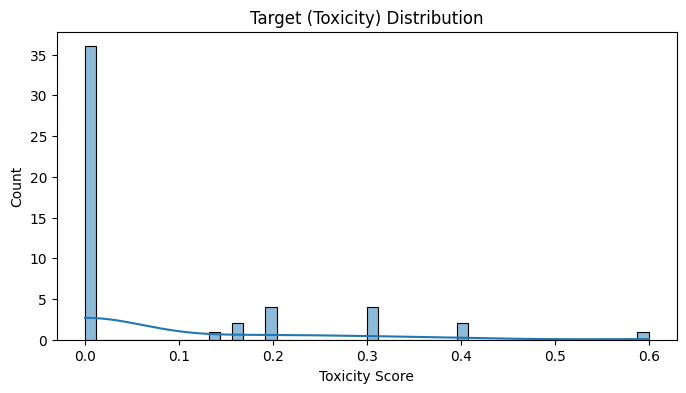

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Reduce dataset size for faster processing
SAMPLE_FRAC = 0.05  # Adjust if needed
train_sample = train_df.sample(frac=SAMPLE_FRAC, random_state=42).reset_index(drop=True)

### ======================= 1. CLASS DISTRIBUTIONS ======================= ###
plt.figure(figsize=(8, 4))
sns.histplot(train_sample['target'], bins=50, kde=True)
plt.title("Target (Toxicity) Distribution")
plt.xlabel("Toxicity Score")
plt.ylabel("Count")
plt.show()

### **4.2 Token Length Distribution**
A histogram illustrates how long the comments are in terms of word count, helping to validate the 128-token limit applied during preprocessing.

**Key takeaway:**

The number of tokens per comment mostly falls between 10 and 50, with a long tail of very lengthy comments. This insight helps determine optimal maximum sequence lengths for BERT tokenization, avoiding memory inefficiency.

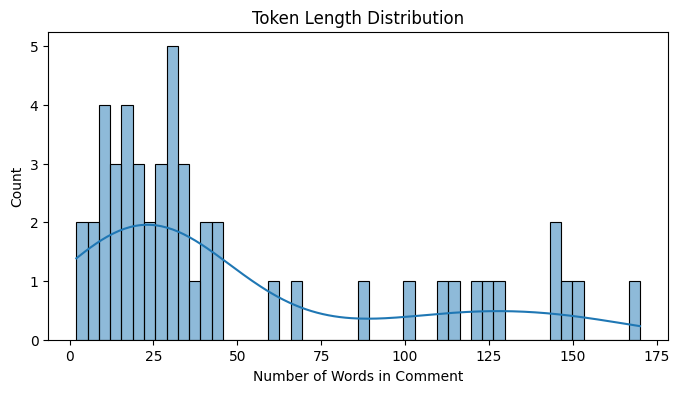

In [14]:
### ======================= 2. TOKEN LENGTH DISTRIBUTION ======================= ###
train_sample["token_length"] = train_sample["comment_text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 4))
sns.histplot(train_sample["token_length"], bins=50, kde=True)
plt.title("Token Length Distribution")
plt.xlabel("Number of Words in Comment")
plt.ylabel("Count")
plt.show()

### **4.3 Word Cloud (Toxic Comments)**
A word cloud is generated from comments with `target > 0.3`, providing a visual summary of frequently occurring toxic words.

**Key takeaway:**

The word cloud reveals frequent terms used in toxic comments. Words like "racist," "trump," and "people" dominate, showing that hate speech and identity-driven toxicity are common. This visualization supports building fairness-aware models.

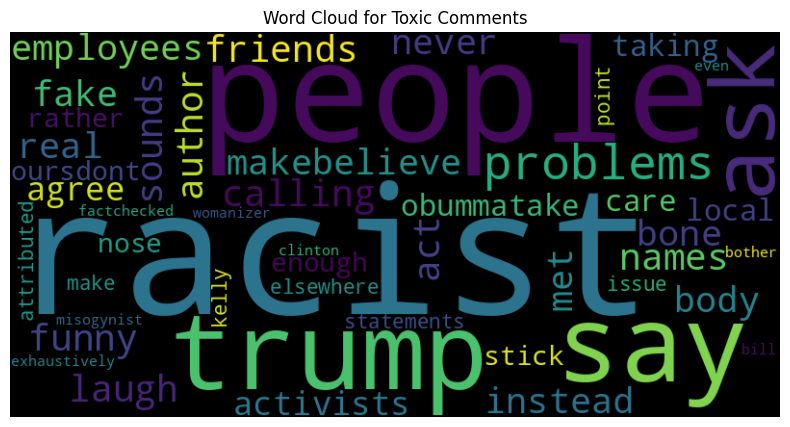

In [15]:
### ======================= 3. WORD CLOUD FOR TOXIC COMMENTS ======================= ###
toxic_comments = " ".join(train_sample.loc[train_sample["target"] > 0.3, "comment_text"].astype(str))

if len(toxic_comments.strip()) > 0:
    wordcloud = WordCloud(width=800, height=400, background_color='black', max_words=100).generate(toxic_comments)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud for Toxic Comments")
    plt.show()
else:
    print("No toxic comments found in the sample. Try adjusting the threshold.")

### **4.4 Word Frequency (Top 20 Words)**
Top 20 most frequent words across all comments are extracted and visualized using a bar chart to identify common vocabulary patterns.

**Key takeaway:**

Unsurprisingly, the most frequent words are generic stopwords such as “the,” “to,” “and,” and “a.” These are generally filtered out during preprocessing but provide a sanity check on the dataset’s text quality.

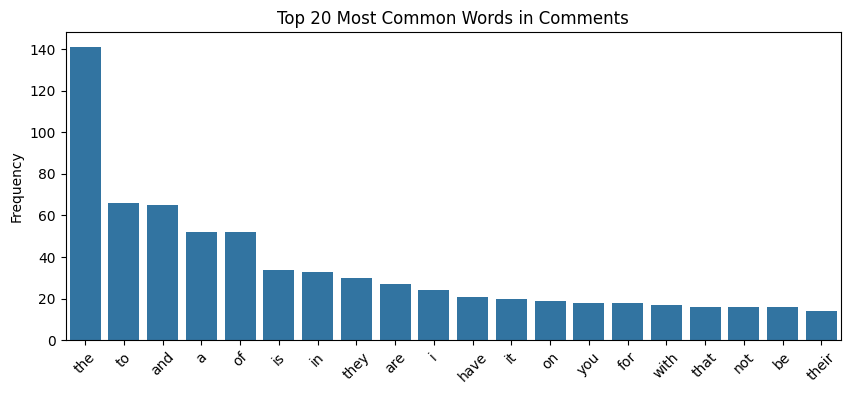

In [16]:
### ======================= 4. WORD FREQUENCY BAR CHART ======================= ###
word_list = " ".join(train_sample["comment_text"].astype(str)).split()
word_counts = Counter(word_list)
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 4))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Words in Comments")
plt.ylabel("Frequency")
plt.show()

### **4.5 Feature Correlation Heatmap**
A heatmap displays pairwise correlations between numeric columns including toxicity and identity attributes, revealing multicollinearity or feature relationships.

**Key takeaway:**

This heatmap illustrates correlations between identity labels (e.g., race, gender, religion) and various toxicity indicators. Strong positive correlations (red) between identity categories and toxic labels highlight potential bias and fairness concerns, reinforcing the need for subgroup-aware evaluation.



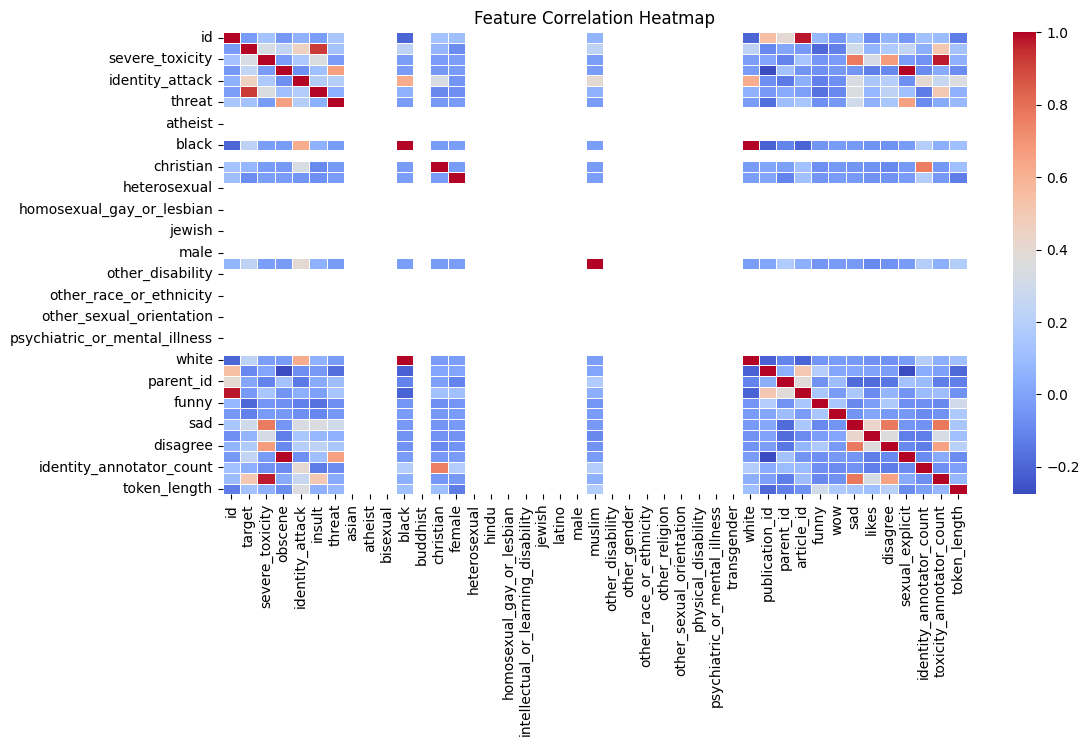

In [18]:
### ======================= 5. CORRELATION HEATMAP ======================= ###
correlation_matrix = train_sample.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()